### 업무 수행자: 최정윤

In [1]:
import os
import sys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
name1 = 'tests'

In [8]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')

# 1. Read Data

Read data from two source & process them for comdty returns

In [9]:
cindex_path = os.path.join(data_path, 'fut1return-com.csv')
cindex1_path = os.path.join(data_path, 'BCOM.csv')

In [10]:
cindex = pd.read_csv(cindex_path, header=0, index_col=0, parse_dates=True)
cindex1 = pd.read_csv(cindex1_path, header=0, index_col=0, parse_dates=True)

In [11]:
CRet = cindex.pct_change(periods=1).iloc[1:]
CRet1 = cindex1.pct_change(periods=1).iloc[1:]
Cindex = (1. + CRet).cumprod()

# 2. Parameter Setting

In [12]:
### parameter setting
RBP = 3
CSNUM = 0.35
CSpos = 0

In [13]:
RB1 = RBP
RB2 = RBP
RET = CRet
index = Cindex
CSdesign = "vol"

In [14]:
RETFinal = CRet

# 3. Calculate Signal

<strong>Commodity Volatility 전략</strong>

- Skewness를 기준으로 Long Short을 한다.
    - skewness: sum((x-np.mean(x)) ** 3/np.var(x) ** (3/2))/len(x)    
    - Skewness가 작은 것을 Long (상위 30%)
    - Skewness * 큰 것을 Short 한다. (하위 30%)

In [15]:
# weather sensitive comdty group
w_group = ["C","S","SB","SM","W","KC","CT"]
n_w_group = [x for x in Cindex.columns if x not in w_group]
c_groups = [w_group, n_w_group]

In [16]:
# Calculate weekly return
def skewness(x):
    return sum((x-np.mean(x))**3/np.var(x)**(3/2))/len(x)

In [17]:
for i in range(2):
    if i == 0:
        RET = CRet[w_group]
    if i == 1:
        RET = CRet[n_w_group]

    index = Cindex[RET.columns]
    
    # neutral zone: 포지션을 잡지 않음
    nopos = 0.4

    # week: 
    minobs1 = 52
    minobs = 260

    # assets to long and short: 0.35
    CS = CSNUM

    # carry score
    Ret = RET

    # business day
    fx = pd.read_csv(os.path.join(data_path, 'fx.csv')) # businnes day
    index = index[index.index.to_series().dt.dayofweek == 1]    
     
    # Skeneww 기준으로 정렬
    ret = pd.DataFrame(index.iloc[1:].to_numpy() / index.iloc[:-1].to_numpy(), columns=index.columns) - 1
    ret.index = index.index[1:]
    STDEV = ret.rolling(window=minobs1).apply(lambda x: skewness(x), raw=True).dropna()
    STDEV.index = ret.index[minobs1-1:]
    RV = -1 * STDEV # multiply -1 for inverse rank
    
    # Rank
    pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    RVrank = RV.expanding().apply(pctrank, raw=True) # it takes some time
    RVrank = RVrank.iloc[minobs1-1:]
    
    truecount = (RVrank.notnull().sum(axis=1) * CS).apply(round)
    tiebreaker = RVrank.rolling(5).mean().fillna(0) * 0.0000001
    
    # 1. Cross sectional
    CSRV = (RVrank + tiebreaker).rank(axis=1, method='first')
    CSRV1 = (-1 * RVrank -1 * tiebreaker).rank(axis=1, method='first')
    
    CSRV = (RVrank + tiebreaker).rank(axis=1, method='first') # Short
    CSRV1 = (-1 * RVrank -1 * tiebreaker).rank(axis=1, method='first') # Long

    CSRVpos = CSRV * 0
    CSRVpos[CSRV.apply(lambda x: x <= truecount, axis=0)] = -1
    CSRVpos[CSRV1.apply(lambda x: x <= truecount, axis=0)] = 1
    
    # Final CS signal
    CSRV = CSRVpos
    
    # 2. Time Series
    TSRV = RVrank * 0 
    TSRV[RVrank > nopos + (1-nopos)/2] = 1 # Long
    TSRV[RVrank < (1-nopos)/2] = -1 # Short
    
    if i == 0:
        TSRVrun1 = TSRV
        CSRVrun1 = CSRV
    else:
        TSRVrun2 = TSRV
        CSRVrun2 = CSRV

# 4. Combine Result

In [20]:
TSRV = pd.concat([TSRVrun1, TSRVrun2], axis=1)
CSRV = pd.concat([CSRVrun1, CSRVrun2], axis=1)

In [21]:
TSRV = TSRV[CRet.columns]
CSRV = CSRV[CRet.columns]

In [24]:
# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
CSRV

,GC,CL,NG,HG,C,S,SI,SB,XBW,SM,BO,W,KC,CT
1993-12-28,1.0,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0
1993-12-29,1.0,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0
1993-12-30,1.0,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0
1993-12-31,1.0,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0
1994-01-03,1.0,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-03,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,0.0,1.0
2018-05-04,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,0.0,1.0
2018-05-07,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,0.0,1.0
2018-05-08,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,0.0,1.0


# 5. Backtest

In [21]:
def ex_ante_vol(df_ret, todate, weights, lookback=130, shrink_corr=0.9):
    '''
    Args:
        df_ret: pandas DataFrame of returns
        todate: date to calculate ex ante vol
        weights: weight of strategy before ex ante vol control
        lookback: number of days to consider for calculating cov
        shrink_corr: weight to shrink correlation
    '''
    # setting data range
    todate_loc = df_ret.index.get_loc(todate)
    if todate_loc > lookback:
        fromdate_loc = todate_loc - lookback
    else:
        fromdate_loc = 0
    
    # calculate corr apply shrinkage
    corr = df_ret.iloc[fromdate_loc:todate_loc].corr()
    corr = corr * shrink_corr + np.diag(np.ones(len(df_ret.columns))) * (1.- shrink_corr)
    # calculate cov
    std = df_ret.iloc[fromdate_loc:todate_loc].std()
    cov = pd.DataFrame(np.diag(std).dot(corr).dot(np.diag(std)), index=RET.columns, columns=RET.columns)
    # calculate ex ante vol
    return np.sqrt(weights.dot(cov).dot(weights)) * np.sqrt(260)

In [22]:
class GRP_bt:
    '''
    '''
    def __init__(self, CSLS, RET, RB, min_vol, freq):
        '''
        '''
        self.CSLS = CSLS  # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 
        self.RET = RET  # 
        self.RB = RB
        
        self.Assetvol = 0.02 # vol control parameter for individual assets
        self.Strategyvol = 0.02 # vol control parameter for whole strategy
        self.factorvol = 0.02
        self.factorsd = 260 # lookback period for calcualting factorvol
        self.assetsd = 90 # lookback period for calculating Assetvol
        self.statsd = 90 # lookback period for calcualting Strategyvol

        self.volband = 0.05 # if controled vol is within volband, do not change vol
        self.min_vol = min_vol # vol floor 0.04 for ir strategy, 0.15 for all otheres
        self.freq = freq # strategy frequency setting. it only applys to Cross Sectional backtesting now.
        
        # Calculating volatility for assets
        std = (self.RET.rolling(window=self.assetsd).std() * np.sqrt(260)).iloc[self.assetsd:]
        # Adjust calculated asset volatility
        self.std_adj = self.adjust_by_volband(std, self.volband, min_vol=self.min_vol)

    def adjust_by_volband(self, df_vol, volband, min_vol=None):
        for i in range(1, len(df_vol.index)):
            if df_vol.iloc[i].name.weekday() == self.RB:
                for c in range(len(df_vol.columns)):
                    # case1. if new std is null
                    if pd.isnull(df_vol.iloc[i, c]):
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                    # case2. if new std within volband
                    if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
            else:
                df_vol.iloc[i] = df_vol.iloc[i-1]
        if min_vol is not None:
            df_vol[df_vol < min_vol] = min_vol

        return df_vol
    
    def ts_vol_control_backtest(self, TSRV):
        # Time Series 
        VCweight = self.Assetvol / self.std_adj
        VCTSpos = (VCweight * TSRV).loc[TSRV.index[0]:] # Vol Control Time Series Position
        VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Strategy level vol control
        # return of VC strategy
        Strategy = ((self.RET * VCTSpos.shift(1)).sum(axis=1)).loc[TSRV.index[0]:]
        # using average of expanding & moving window strategy risk
        Strategyrisk_expanding = (Strategy.expanding(min_periods=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk_rolling = (Strategy.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
        # volband adjustment
        bufrisk = self.adjust_by_volband(Strategyrisk.copy().to_frame(), self.volband)
        # apply strategy level vol control to position
        statlev = self.Strategyvol / bufrisk.iloc[:,0]
        self.TSposition = VCTSpos.multiply(statlev, axis='index').iloc[self.statsd:]
        self.TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.TSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.TSStrategy = (self.RET * self.TSposition.shift(1)).sum(axis=1).loc[TSRV.index[0]:]
        self.TSStrategylag = (self.RET * self.TSposition.shift(2)).sum(axis=1).loc[TSRV.index[0]:]
    
    def cs_vol_control_backtest(self, CSRV):
        if self.CSLS == 'vol':
            CSRV = (CSRV * self.Assetvol / self.std_adj).loc[CSRV.index[0]:]
        #elif self.CSLS != 'notional': # raise error
            
        # Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
        if self.freq == 'week':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.weekday() == self.RB:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        elif self.freq == 'month':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.month != CSRV.iloc[i-1].name.month:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        #else: # raise error
            
        # Strategy level vol control
        # return of VC strategy
        CSraw = (self.RET * CSRV.shift(1)).dropna(how='all').sum(axis=1)
        CSrisk = (CSraw.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        
        # volband adjustment
        cs_bufrisk = self.adjust_by_volband(CSrisk.to_frame(), self.volband)
        # apply strategy level vol control to position
        cs_statlev = self.Strategyvol / cs_bufrisk.iloc[:,0]
        self.CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[self.statsd:]
        self.CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.CSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.CSStrategy = (self.RET * self.CSposition.shift(1)).sum(axis=1).loc[CSRV.index[0]:]
        self.CSStrategylag = (self.RET * self.CSposition.shift(2)).sum(axis=1).loc[CSRV.index[0]:]

In [1]:
import pandas as pd

### TS

In [23]:
RET = RETFinal

In [26]:
GRP_bt_test = GRP_bt(CSLS='vol', RET=RET, RB=RBP, min_vol=0.15, freq='week')
GRP_bt_test.ts_vol_control_backtest(TSRV)

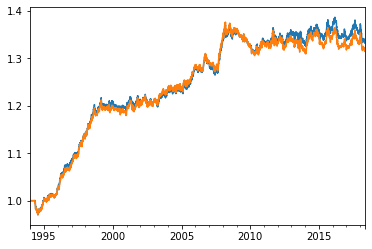

In [27]:
(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

### CS

In [28]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

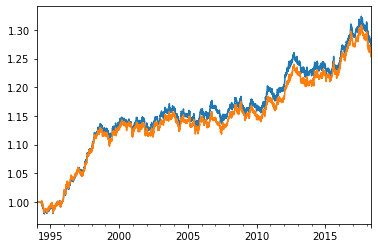

In [29]:
(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()